In [1]:
from os import listdir
from os.path import isfile, join
mypath = "../images"
file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(str(len(file_names)) + ' images loaded')

93 images loaded


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras.applications.resnet50 import preprocess_input

import matplotlib.pyplot as plt
import numpy as np

import cv2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [3]:
from joblib import dump, load

In [4]:
#function to preprocess normal image 
def prepocessImage(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
    frame = img
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    sensitivity = 156
    lower_white = np.array([0,0,255-sensitivity])
    upper_white = np.array([255,sensitivity,255])
    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame,frame, mask= mask)
    ret, thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY_INV)
    circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 1.5, 100000,param1=80,param2=40,minRadius=0,maxRadius=0)
    x,y,r = 0,0,0
    if circles is not None:
      circles = np.uint16(np.around(circles))
      x,y,r = circles[0][0]
      x=int(x)
      y=int(y)
      r=int(r)
    mask = np.zeros((224,224), np.uint8)
    cv2.circle(mask,(x,y),r,(255,255,255),-1)
    masked_data = cv2.bitwise_and(frame, frame, mask=mask)
    _,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)
    cnt = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
    x,y,w,h = cv2.boundingRect(cnt[0])

    # Crop masked_data
    crop = masked_data[y:y+h,x:x+w]
    crop = cv2.resize(crop, (224,224), interpolation = cv2.INTER_AREA)
    #preprocess the image
    my_image = preprocess_input(crop)
    crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
#     my_image = img_to_array(crop)
#     plt.imshow(my_image)
#     my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
#     return my_image
#     preprocessed shape = (1,224,224,1)
    return crop

In [5]:
# from skimage.feature import  graycomatrix, graycoprops
images_sift = []
# glcm=[]
labels = []
size = 128
sift = cv2.SIFT_create()
cataract=0
normal=0
for i, file in enumerate(file_names):
#         print(file)
        image = cv2.imread(mypath+"/"+file,0)
        h,w=image.shape
#         if(h>128 and w>128):
        img = prepocessImage(mypath+"/"+file)
#         image = cv2.resize(img, (size, size), interpolation = cv2.INTER_AREA)
        img_arr = np.array(img)
#         gCoMat = graycomatrix(img_arr, [1], [0],256,symmetric=True, normed=True) # Co-occurance matrix
#         contrast = graycoprops(gCoMat, prop='contrast')[0][0]
#         dissimilarity = graycoprops(gCoMat, prop='dissimilarity')[0][0]
#         homogeneity = graycoprops(gCoMat, prop='homogeneity')[0][0]
#         energy = graycoprops(gCoMat, prop='energy')[0][0]
#         correlation = graycoprops(gCoMat, prop='correlation')[0][0]
        keypoints, descriptors = sift.detectAndCompute(image,None)
        descriptors=np.array(descriptors)
        descriptors=descriptors.flatten()
#         glcm.append([contrast,dissimilarity,homogeneity,energy,correlation])
#         images_sift.append(len(descriptors))
        images_sift.append(descriptors[:3456])

        #print(descriptors.shape)
        if file_names[i][0] == "c":
            cataract+=1
            labels.append(1)
        if file_names[i][0] == "n":
            normal+=1
            labels.append(0)

print("Testing and validation split done!")

Testing and validation split done!


In [6]:
images_sift=np.array(images_sift)
images_sift.shape

(93, 3456)

In [7]:
from sklearn import preprocessing
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(12,10)})

In [22]:
df=pd.DataFrame(data=images_sift)
df['label']=labels
df=df.sample(frac=1)
X=df.drop(['label'], axis = 1)
y=df['label']


#Different model
X_train_images_sift, X_test_images_sift, y_train_images_sift, y_test_images_sift = train_test_split(X, y, test_size=0.25,random_state=87)

In [23]:
svM = load('Phase1_svm.joblib')
prediction_test = svM.predict(X=X_test_images_sift)
acc_score=accuracy_score(y_test_images_sift,prediction_test)
print("acc_score: ", acc_score)
scores = cross_val_score(svM, X_test_images_sift, y_test_images_sift, cv=5)
mean=scores.mean()
print("svm_cross_val :",mean)

acc_score:  0.9166666666666666
svm_cross_val : 0.76


In [24]:
svM.coef_[0]    

array([0.000060, 0.000002, -0.000117, ..., 0.000109, 0.000020, -0.000059])

In [26]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

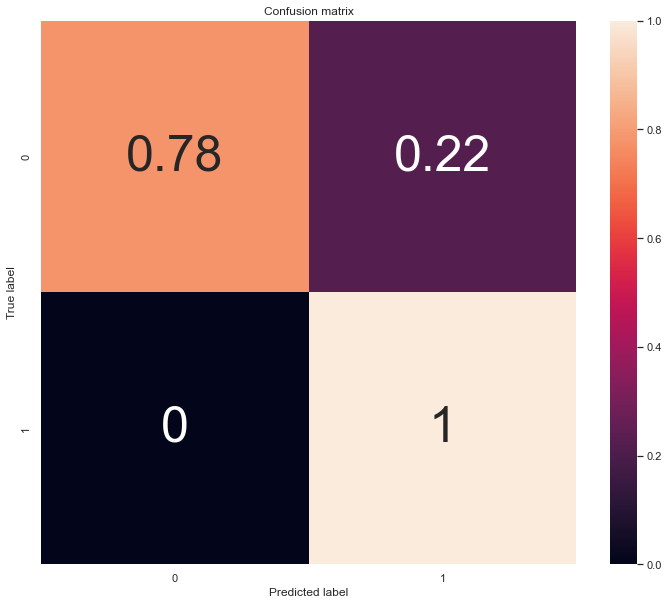

In [28]:
cm = confusion_matrix(y_test_images_sift, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=svM.classes_,
title='Confusion matrix')